In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output

import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import time
from datetime import datetime
import 

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [2]:
from two_axis_inverted_pendulum_env import TwoAxisInvertedPendulum
from brax.envs.base import Env, PipelineEnv, State

In [4]:
envs.register_environment("TwoAxisInvertedPendulum", TwoAxisInvertedPendulum)
env = envs.get_environment("TwoAxisInvertedPendulum")

# required for parallelizing training
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# Initial Rollout
Visualizing a random policy.

In [5]:
ROLLOUT_LENGTH = 1000

In [ ]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

rollout = [state.pipeline_state]
rollout_reward = [state.metrics['reward']]
x_angle, y_angle = [state.obs[0]], [state.obs[1]]


for _ in range(ROLLOUT_LENGTH-1):
    rng, _ = jax.random.split(rng)
    action = jax.random.uniform(rng, (env.action_size,), minval=-1, maxval=1) 
    state = jit_step(state, action)
    if state.done != 0: 
        state = jit_reset(rng)
        
    rollout.append(state.pipeline_state)
    rollout_reward.append(state.metrics['reward'])
    x_angle.append(state.obs[0])
    y_angle.append(state.obs[1])

### Use to display render in line
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

### Use to save render to file
# html_content = html.render(env.sys, rollout)
# with open('untrained_rollout.html', 'w') as out:
#     out.write(html_content)

In [ ]:
plt.figure(figsize=(10,10))

plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.plot(rollout_reward)
plt.show()

# Training
Using fuctools to call PPO.

For my future use:
- `reward_scaling`: ...
- `action_repeat`: ...
- `unroll_length`: ...

In [11]:
# still fine tuning?
train_fn = functools.partial(
    ppo.train,
    num_timesteps=40_000_000, 
    num_evals=20,
    reward_scaling=10,
    episode_length=1000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, 
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, 
    batch_size=2048,
    seed=1
)

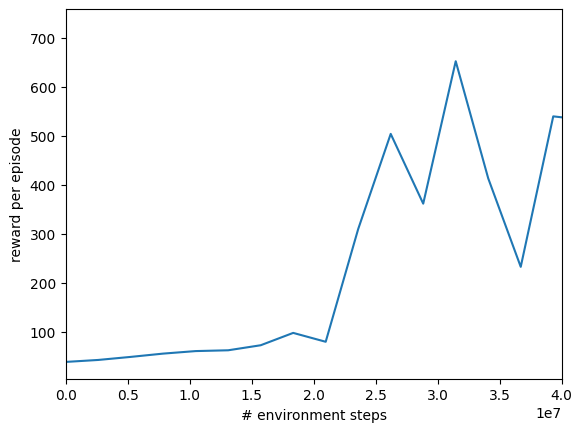

Time to train 31.290422 minutes.


In [12]:
# code was borrowed from Brax's `tutorial` collab notebook

xdata, ydata = [], []
times = [datetime.now()]
def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()

time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()
print(f"Time to train {(time_end - time_start) / 60 :2f} minutes.")

In [13]:
model.save_params("policy_2.5", params)
params = model.load_params("policy_2.5")
inference_fn = make_inference_fn(params) 
jit_inference_fn = jax.jit(inference_fn)

## Trained Rollout

In [14]:
rng = jax.random.PRNGKey(0)

state = jit_reset(rng)
rollout = [state.pipeline_state]
rollout_reward = [state.metrics['reward']]
pos = [state.obs[:2]]
x_angle, y_angle = [state.obs[0]], [state.obs[1]]


for _ in range(ROLLOUT_LENGTH):
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, act)
    
    if state.done != 0:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    rollout_reward.append(state.metrics['reward'])
    pos.append(state.obs[:2])
    x_angle.append(state.obs[0])
    y_angle.append(state.obs[1])

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))


# html_content = html.render(env.sys, rollout)
# with open('trained_rollout_v2.html', 'w') as f:
#     f.write(html_content)

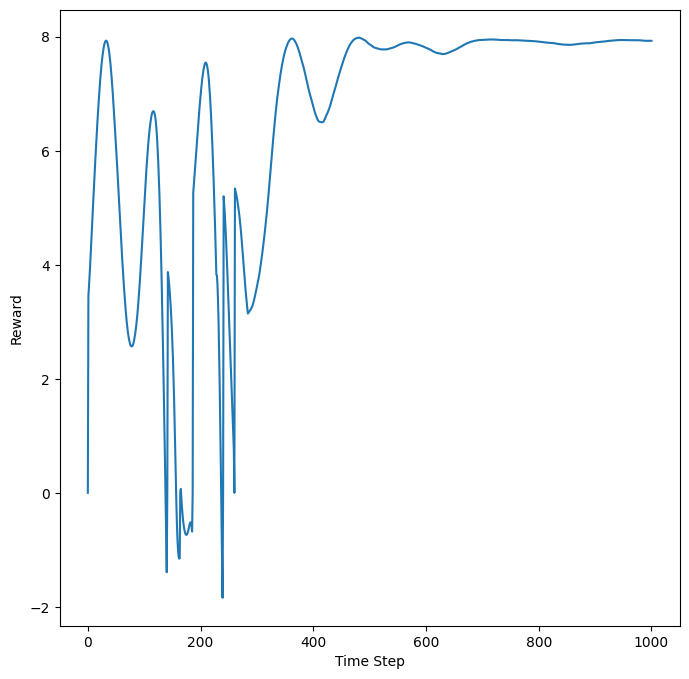

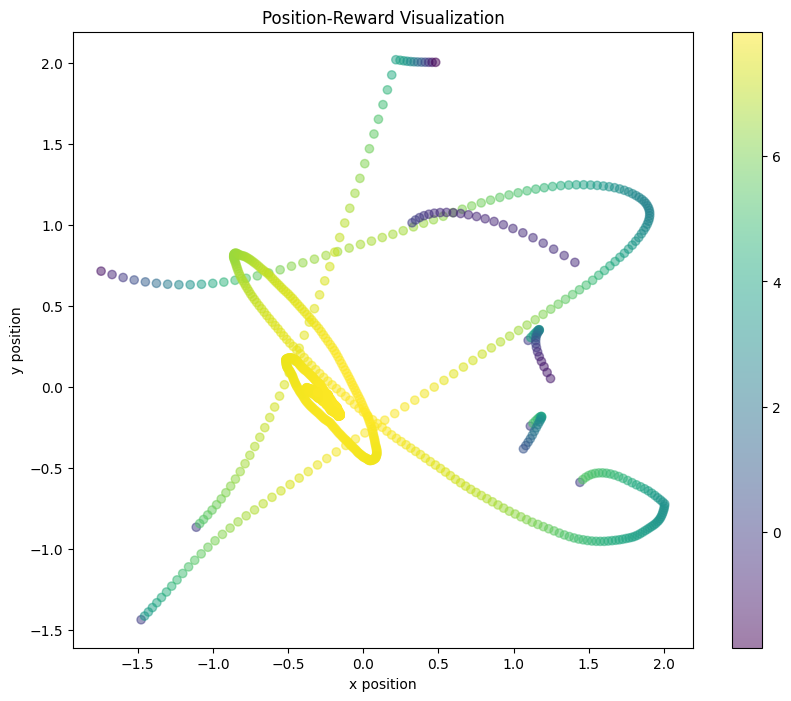

In [15]:
plt.figure(figsize=(8,8))
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.plot(rollout_reward)
plt.show()


plt.figure(figsize=(10,8))
x_pos = [a[0] for a in pos]
y_pos = [a[1] for a in pos]
plt.title("Position-Reward Visualization")
plt.xlabel("x position")
plt.ylabel("y position")
plt.scatter(x_pos, y_pos, c=rollout_reward, alpha=0.5)
plt.colorbar()
plt.show()

